# SANTANDER VALUE PREDICTION CHALLENGE (TRAIN MULTIPLE MODELS)

**Import neccessary modules and packages**

In [1]:
import numpy as np 
import pandas as pd 
from scipy.stats import skew
from scipy.stats import ks_2samp
import tensorflow as tf
from tensorflow.python.framework import ops
ops.reset_default_graph()
from functools import partial
import matplotlib
import matplotlib.pyplot as plt
import progressbar

**Set the random seed of numpy and tensorflow**

In [2]:
# np_rand_seed = np.random.randint(0,100)
# tf_rand_seed = np.random.randint(0,100)
np_rand_seed = 0
tf_rand_seed = 1
np.random.seed(np_rand_seed)
tf.set_random_seed(tf_rand_seed)
print("numpy random seed: ",np_rand_seed)
print("tensorflow random seed: ", tf_rand_seed)

numpy random seed:  0
tensorflow random seed:  1


## 1. Load and preprocess data

### 1.1 Load and display data

In [3]:
data = pd.read_csv("../input/train.csv")
data = data.sample(frac=1).reset_index(drop=True)

In [4]:
test_data = pd.read_csv("../input/test.csv")
test_id = test_data.ID.tolist()

In [5]:
data.head(20)

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,a699ddd5b,32000000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.00,0,0,0,0,0,0,0
1,83587ad6e,400000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.00,0,0,0,0,0,0,0
2,e62c51273,10000000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.00,0,0,0,0,0,0,0
3,588b8f63e,8470000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.00,0,0,0,0,0,0,0
4,ac3b2a385,10000000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.00,0,0,0,0,0,0,0
5,08d27660b,3734230.76,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.00,0,0,0,0,0,0,0
6,76e1918a1,31000000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.00,0,0,0,0,0,0,0
7,48b984180,340000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.00,0,0,0,0,0,0,0
8,120eb3f4b,800000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.00,0,0,0,0,0,0,0
9,ce20ac9be,1310000.00,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.00,0,0,0,0,0,0,0


### 1.2 Preliminary data prerocessing

**Drop the ID column**

In [6]:
data = data.drop('ID', axis=1)
test_data = test_data.drop('ID', axis=1)

**Fill missing values with column means**

In [7]:
data = data.fillna(data.mean())
test_data = test_data.fillna(data.mean())

**Convert the data type to float 32**

In [8]:
data = data.astype('float32')
test_data = test_data.astype('float32')

**Extract the features**

In [9]:
features = data.columns.tolist()
output = 'target'
features.remove(output)

### 1.3 Discard single value feature

**A function to discard single value features**

In [10]:
def discard_features_single_value(train_data, features):
    
    '''A function to discard single value features'''
    
    discarded_features = train_data.columns[train_data.nunique() == 1]
    
    selected_features = []
    
    for feature in features:
        if feature not in discarded_features:
            selected_features.append(feature)
        
    # return the lists of selected and discarded features
    return selected_features, discarded_features

In [11]:
selected_features, discarded_features = discard_features_single_value(data, features)
print("Length of selected features:", len(selected_features))

Length of selected features: 4735


**Drop the discarded features**

In [12]:
data = data.drop(discarded_features, axis=1)
test_data = test_data.drop(discarded_features, axis=1)
features = selected_features

### 1.4 Discard duplicated features

**A function to discard dublicated features**

In [13]:
def discard_duplicated_features(train_data, features):
    
    '''A function to discard dublicated features'''
    
    discarded_features = []    
    selected_features = []
    
    for i in range(len(features)-1):
        v = train_data[features[i]].values
        for j in range(i + 1,len(features)):
            if np.array_equal(v, train_data[features[j]].values):
                discarded_features.append(features[j])
                
    for feature in features:
        if feature not in discarded_features:
            selected_features.append(feature)
        
    # return the lists of selected and discarded features
    return selected_features, discarded_features

In [14]:
selected_features, discarded_features = discard_duplicated_features(data, features)
print("Length of selected features:", len(selected_features))

Length of selected features: 4730


**Drop the discarded features**

In [15]:
data = data.drop(discarded_features, axis=1)
test_data = test_data.drop(discarded_features, axis=1)
features = selected_features

### 1.5 Discard features based on Kolmogorov-Smirnov test

**A function to discard features based on Kolmogorov-Smirnov test**

In [16]:
def select_features_ks_2samp(train_data, test_data, features, THRESHOLD_P_VALUE = 0.01, THRESHOLD_STATISTIC = 0.3):
    
    '''A function to discard features based on Kolmogorov-Smirnov test'''
    
    selected_features = []
    discarded_features = []
    
    for feature in features:
        statistic, pvalue = ks_2samp(train_data[feature].values, test_data[feature].values)
        if pvalue <= THRESHOLD_P_VALUE and np.abs(statistic) > THRESHOLD_STATISTIC:
            discarded_features.append(feature)
        else:
            selected_features.append(feature)
            
    # return the lists of selected and discarded features
    return selected_features, discarded_features

In [17]:
selected_features, discarded_features = select_features_ks_2samp(data, test_data, features, THRESHOLD_P_VALUE = 0.01, THRESHOLD_STATISTIC = 0.05)
print("Length of selected features:", len(selected_features))

Length of selected features: 4148


**Drop the discarded features**

In [18]:
data = data.drop(discarded_features, axis=1)
test_data = test_data.drop(discarded_features, axis=1)
features = selected_features 

### 1.6 Discard features based on correlation

**A function to discard features based on correlation**

In [19]:
def select_features(data, features, output, threshold):
    
    '''A function to discard features based on correlation'''
    
    # a list to store the selected and discarded features
    selected_features = []
    discarded_features = []
    
    # iterate through each feature 
    for feature in features:
        # compute correlation between feature and output
        corr = data[output].corr(data[feature])
        # select feature if the correlation is above threshold
        if abs(corr)>=threshold:
            selected_features.append(feature)
        else:
            discarded_features.append(feature)
    
    # return the lists of selected and discarded features
    return selected_features, discarded_features

In [20]:
selected_features, discarded_features = select_features(data,features, output, 0.01)
print("Length of selected features:", len(selected_features))

Length of selected features: 2419


**Drop the discarded features**

In [21]:
data = data.drop(discarded_features, axis=1)
test_data = test_data.drop(discarded_features, axis=1)
features = selected_features 

### 1.7 Scale features

**A function to scale data given a scaler and list of features**

In [22]:
def feature_scaler(scaler, data, features, test_data = False):
    
    '''A function to scale data given a scaler and list of features'''

    # extract all the columns in the pandas dataframe
    all_columns = data.columns.values.tolist()
    # extract the rest of the features that are not selected for scaling
    rest_of_cols = [feature for feature in all_columns if feature not in features]

    # extract the unselected columns of the data and store it in a dataframe
    rest = data[rest_of_cols]
    # scale the columns of the selected featues of the training data
    if not test_data:
        feature = scaler.fit_transform(data[features])
    else:
        feature = scaler.transform(data[features])
    # above operation returns a numpy array,
    # so we convert this into pandas dataframe with the features as the column names
    scaled_data = pd.DataFrame(feature, columns = features)
    # add the rest of the unscaled column to the above dataframe to complete the dataframe
    for col in rest_of_cols:
        scaled_data[col] = rest[col].values

    # return the scaled data and the scaler
    return scaled_data, scaler

**Create a scalar object**

In [23]:
# import the minmax scaler module from scikit learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
# create a scalar object that scales data into a range of -1 to 1
scaler = MinMaxScaler((0,1))

**Scale the train & test data**

In [24]:
data, scaler = feature_scaler(scaler, data, features)
test_data, scaler = feature_scaler(scaler, test_data, features, test_data=True)

### 1.8 Create new features 

In [25]:
data_tmp = data[features].copy()
test_data_tmp = test_data[features].copy()

In [26]:
data["sum"] = data_tmp.sum(axis=1)
test_data["sum"] = test_data_tmp.sum(axis=1)
data["var"] = data_tmp.var(axis=1)
test_data["var"] = test_data_tmp.var(axis=1)
data["median"] = data_tmp.median(axis=1)
test_data["median"] = test_data_tmp.median(axis=1)
data["mean"] = data_tmp.mean(axis=1)
test_data["mean"] = test_data_tmp.mean(axis=1)
data["std"] = data_tmp.std(axis=1)
test_data["std"] = test_data_tmp.std(axis=1)
data["max"] = data_tmp.max(axis=1)
test_data["max"] = test_data_tmp.max(axis=1)
data["min"] = data_tmp.min(axis=1)
test_data["min"] = test_data_tmp.min(axis=1)
data["skew"] = data_tmp.skew(axis=1)
test_data["skew"] = test_data_tmp.skew(axis=1)
data["kurtosis"] = data_tmp.kurtosis(axis=1)
test_data["kurtosis"] = test_data_tmp.kurtosis(axis=1)
del(test_data_tmp)
del(data_tmp)

In [27]:
print("Shape of train data:", data.shape)
print("Shape of test data:", test_data.shape)

Shape of train data: (4459, 2429)
Shape of test data: (49342, 2428)


### 1.9 Log transformation of skewed data

In [28]:
skewed_feats = data[features].apply(lambda x: skew(x)) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 2]
skewed_feats = skewed_feats.index.tolist()
print("Number of skewed features:", len(skewed_feats))
data[skewed_feats] = np.log1p(data[skewed_feats])
test_data[skewed_feats] = np.log1p(test_data[skewed_feats])

Number of skewed features: 2419


In [29]:
features = data.columns.tolist()
output = 'target'
features.remove(output)

In [30]:
# from sklearn.covariance import EllipticEnvelope
# outliers_fraction = 0.01
# outlier_detection= ElalipticEnvelope(contamination=outliers_fraction)
# outlier_detection.fit(data[features])
# preds = outlier_detection.predict(data[features])
# outliers = preds==1
# data = data.loc[outliers]

### 1.10 Train test split the train set

In [31]:
from sklearn.model_selection import train_test_split
train_data, valid_data = train_test_split(data, test_size = 0.10, random_state = 1)

In [32]:
train_data.head()

,48df886f9,0deb4b6a8,34b15f335,2f0771a37,30347e683,6ee66e115,dc5a8f1d8,77c9823f2,8d6c2a0b2,adf119b9a,...,target,sum,var,median,mean,std,max,min,skew,kurtosis
4137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.066667e+05,0.827023,6.280479e-06,0.0,3.418862e-04,0.002506,0.026690,0.0,7.595515,57.896122
794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.542000e+06,0.000634,1.660352e-10,0.0,2.619884e-07,0.000013,0.000634,0.0,49.183331,2419.000000
2534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.070000e+05,42.156421,4.068944e-03,0.0,1.742721e-02,0.063788,1.000000,0.0,7.019270,70.107522
3746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000e+07,6.104486,8.313252e-04,0.0,2.523558e-03,0.028833,1.000000,0.0,21.539641,636.029021
1396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.250000e+07,43.044428,1.093997e-02,0.0,1.779431e-02,0.104594,1.000000,0.0,6.669603,47.676821


In [33]:
print("Shape of train data:",train_data.shape)

Shape of train data: (4013, 2429)


In [34]:
valid_data.head()

,48df886f9,0deb4b6a8,34b15f335,2f0771a37,30347e683,6ee66e115,dc5a8f1d8,77c9823f2,8d6c2a0b2,adf119b9a,...,target,sum,var,median,mean,std,max,min,skew,kurtosis
2012,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.400000e+06,2.321911,3.193551e-04,0.0,0.000960,0.017871,0.716000,0.0,30.777772,1121.798607
3205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.000000e+07,0.233856,1.575028e-05,0.0,0.000097,0.003969,0.194049,0.0,48.359108,2362.176518
2359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.286667e+05,0.008000,2.645721e-08,0.0,0.000003,0.000163,0.008000,0.0,49.183331,2419.000000
4387,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.400000e+06,1.502399,4.315184e-04,0.0,0.000621,0.020773,1.000000,0.0,46.341983,2219.700308
3116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.000000e+05,0.535550,3.147828e-05,0.0,0.000221,0.005611,0.240000,0.0,35.522141,1425.804188


In [35]:
print("Shape of valid data:",valid_data.shape)

Shape of valid data: (446, 2429)


### 2.1 Create X y data

**Create X y data for train set**

In [36]:
X_train = train_data[features].as_matrix()
y_train = train_data[output].as_matrix()
X_valid = valid_data[features].as_matrix()
y_valid = valid_data[output].as_matrix()

**Create X data for test set**

In [37]:
X_test = test_data[features].as_matrix()
del(test_data)

## 2. Multiple model hyperparameter generator

**Generate a list of learning rates**

In [38]:
learning_rates = np.round(np.logspace(-4,-3,num=200),4)
print(learning_rates)

[ 0.0001  0.0001  0.0001  0.0001  0.0001  0.0001  0.0001  0.0001  0.0001
  0.0001  0.0001  0.0001  0.0001  0.0001  0.0001  0.0001  0.0001  0.0001
  0.0001  0.0001  0.0001  0.0001  0.0001  0.0001  0.0001  0.0001  0.0001
  0.0001  0.0001  0.0001  0.0001  0.0001  0.0001  0.0001  0.0001  0.0001
  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002
  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002
  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002
  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002
  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002  0.0002  0.0003
  0.0003  0.0003  0.0003  0.0003  0.0003  0.0003  0.0003  0.0003  0.0003
  0.0003  0.0003  0.0003  0.0003  0.0003  0.0003  0.0003  0.0003  0.0003
  0.0003  0.0003  0.0003  0.0003  0.0003  0.0003  0.0003  0.0003  0.0003
  0.0003  0.0004  0.0004  0.0004  0.0004  0.0004  0.0004  0.0004  0.0004
  0.0004  0.0004  0.0004  0.0004  0.0004  0.0004  0

**Generate a list of stddevs**

In [39]:
stddevs = np.round(np.logspace(-2.301,-1.301,num=100),4)
print(stddevs)

[ 0.005   0.0051  0.0052  0.0054  0.0055  0.0056  0.0057  0.0059  0.006
  0.0062  0.0063  0.0065  0.0066  0.0068  0.0069  0.0071  0.0073  0.0074
  0.0076  0.0078  0.008   0.0081  0.0083  0.0085  0.0087  0.0089  0.0092
  0.0094  0.0096  0.0098  0.01    0.0103  0.0105  0.0108  0.011   0.0113
  0.0116  0.0118  0.0121  0.0124  0.0127  0.013   0.0133  0.0136  0.0139
  0.0142  0.0146  0.0149  0.0153  0.0156  0.016   0.0164  0.0168  0.0172
  0.0176  0.018   0.0184  0.0188  0.0193  0.0197  0.0202  0.0207  0.0211
  0.0216  0.0222  0.0227  0.0232  0.0238  0.0243  0.0249  0.0255  0.0261
  0.0267  0.0273  0.028   0.0286  0.0293  0.03    0.0307  0.0314  0.0321
  0.0329  0.0337  0.0345  0.0353  0.0361  0.037   0.0378  0.0387  0.0396
  0.0406  0.0415  0.0425  0.0435  0.0445  0.0456  0.0466  0.0477  0.0489
  0.05  ]


**A function to generate a single layer dimension**

In [40]:
def layer_dim_generate(layer_sizes):
    
    '''A function to generate a single layer dimension'''
    
    layer_sizes_copy = layer_sizes[:]    
    num_hidden = np.random.randint(low = 6, high = 20)
    layer_dims = []
    
    for n in range(num_hidden):        
        layer_dims.append(layer_sizes_copy[0])            
        if np.random.uniform(0, 1)>0.65 and len(layer_sizes_copy)>1:
            layer_sizes_copy.pop(0)
            
    return layer_dims

**A function to generate multiple layer dimensions**

In [41]:
def layer_dim_generator(number, layer_sizes):
    
    '''A function to generate multiple layer dimensions'''    
    layers = []
    for i in range(number):
        layers.append(layer_dim_generate(layer_sizes))
    return layers

**A function to randomly generate a given number of learning rates**

In [42]:
def learning_rate_generator(learning_rates, number, randome_seed = 0):
    
    '''A function to randomly generate a given number of learning rates'''    
    np.random.seed(randome_seed)
    
    return np.random.choice(learning_rates, size=number).tolist()

**A function to randomly generate a given number of stddevs**

In [43]:
def stddev_generator(stddevs, number, randome_seed = 0):
    
    '''A function to randomly generate a given number of stddevs'''    
    np.random.seed(randome_seed)
    
    return np.random.choice(stddevs, size=number).tolist()

**A function which generate a list of set of hypterparameters using caviar strategy search**

In [44]:
def caviar_strategy_search(number, layer_sizes, learning_rates, stddevs, random_seed =0):
    
    '''A function which generate a list of set of hypterparameters using caviar strategy search'''
    
    learning_rate_list = learning_rate_generator(learning_rates, number, randome_seed = random_seed)
    stddev_list = stddev_generator(stddevs, number, randome_seed = random_seed)
    model_architecture_list  = layer_dim_generator(number, layer_sizes)
    
    return learning_rate_list, stddev_list, model_architecture_list

**Generate a given number of sets of hyperparameters**

In [45]:
layer_sizes = [128,64,32,16]
numbers = 8
learning_rate_list, stddev_list, model_architecture_list = caviar_strategy_search(numbers, layer_sizes, learning_rates,stddevs)

## 3. Create graph and train multiple models

**Import tensorflow and print out the list of devices**

In [46]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()
print(devices)

[name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5390482321518887417
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 11310504346
locality {
  bus_id: 1
}
incarnation: 6557630667826411839
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0"
]


**Select GPU as computation device if there are any**

In [47]:
if len(devices)>1:
    device = devices[1].name
else:
    device = devices[0].name

### 3.1 A function to create dnn regressor graph

In [48]:
def create_dnn_graph(layers, input_dim, output_dim, stddev, learning_rate):
    
    '''A function to create the dnn regressor graph'''
    
    # create placeholders
    X = tf.placeholder(tf.float32, shape=[None,input_dim])
    y = tf.placeholder(tf.float32, shape=[None,output_dim])
    keep_prob = tf.placeholder(tf.float32)
    
    # iterate throug each layer dimension and create a dense layer
    for n,layer in enumerate(layers):
        # for the first layer
        if n == 0:
            with tf.device(device):
                X_input = tf.layers.dense(X,layer, activation=tf.nn.relu, kernel_initializer=tf.truncated_normal_initializer(stddev= stddev))
                X_input = tf.nn.dropout(X_input, keep_prob)
        # for rest of the layers
        else:
            with tf.device(device):
                X_input = tf.layers.dense(X_input,layer, activation=tf.nn.relu, kernel_initializer=tf.truncated_normal_initializer(stddev= stddev))
                X_input = tf.nn.dropout(X_input, keep_prob)
    
    # create the output layer of dnn regressor
    with tf.device(device):
        y_= tf.layers.dense(X_input,output_dim)
    # create the rmsle operation
    with tf.device(device):
        cost = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(tf.log(y_+1.0),tf.log(y+1.0)))))
    #create train operation
    with tf.device(device):
        train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # return placeholders and operations
    return X, y, y_, keep_prob, cost, train_step

### 3.2 A function to train dnn model

In [49]:
def train_graph(saver, max_iter, batch_size,X_train, y_train, X_valid, y_valid, 
                X, y, y_, keep_prob, loss, train_step, model_name):
    
    '''A function to train dnn regressor model'''
    
    # list to store the train and validation loss through iterations
    train_cost = []
    valid_cost = []
    
    # variables to store the cost, iteration of our best model
    best_cost = 1000000
    best_iteration = None

    # iteration counter
    iteration = 1
    # model directory
    model_dir = './model_files/'

    # create a graph session and train dnn
    with tf.Session() as sess:

        # initialize variables
        sess.run(tf.global_variables_initializer())
        
        bar = progressbar.ProgressBar(maxval=max_iter, widgets=[
            ' [',progressbar.Percentage(),'] ',
            progressbar.Bar(),
            ' (',progressbar.DynamicMessage("train_loss"),')',
            ' (',progressbar.DynamicMessage("valid_loss"),')',
        ])
        bar.start()

        for i in range(max_iter):

            # break if max iteration is reached
            if iteration > max_iter:
                break

            # randomly choosing the indices of the batch 
            rand_index = np.random.choice(X_train.shape[0], size=batch_size)

            # extract the batch X y data
            X_batch = X_train[rand_index]
            y_batch = y_train[rand_index]

            # feed dict for train batch
            feed_dict_batch =  {X: X_batch,
                                y: np.transpose([y_batch]),
                                keep_prob: 0.75}
            # feed dict for validation
            feed_dict_valid =  {X: X_valid,
                                y: np.transpose([y_valid]),
                                keep_prob: 1.0}
            # compute train operation
            sess.run(train_step, feed_dict=feed_dict_batch)

            # calculate temporary train cost and append it to the designated list
            temp_train_cost = loss.eval(session=sess, feed_dict=feed_dict_batch)
            train_cost.append(temp_train_cost)
            # calculate temporary validation cost and append it to the designated list
            temp_validation_cost = loss.eval(session=sess, feed_dict=feed_dict_valid)
            valid_cost.append(temp_validation_cost)
                
            # saver path
            saver_path = model_dir+model_name

            # if the valid loss is tied with best recorded so far then
            # update the parameters of the best model and save the model
            if temp_validation_cost < best_cost:
                best_cost = temp_validation_cost
                best_iteration = iteration          
                saver.save(sess, saver_path, global_step = best_iteration) 
                
            # update the progress bar
            bar.update(i+1, train_loss = temp_train_cost, valid_loss = temp_validation_cost)

            # increment iteration
            iteration = iteration+1
            
        # finish the progress bar
        bar.finish()
            
    # model path
    model_path = model_dir+model_name+"-"+str(best_iteration)
    
    # return neccessary variables
    return train_cost, valid_cost, model_path, best_cost, best_iteration

### 3.3 A function to compute predictions

In [50]:
def compute_predictions(saver, model_path, X_test, y_, keep_prob, verbose = False):
    
    '''A function to compute predictions given a saver and model path'''
    
    with tf.Session() as sess:  
    
        # restore model from the saver object
        saver.restore(sess, model_path)
        # break the test set into k folds other wise kernel will be out of length
        n = len(test_id)
        k = 40
        step = n//k

        # array to store the prediction
        preds = np.array([])

        # iterate through each fold and calculate the start and end indices of the fold
        for i in range(k):            
            if i != (k-1):
                start = (step*i)
                end = (step*(i+1)) 
            # end case
            else:
                start = (step*i)
                end = len(test_id)

            # feed dict of the fold
            feed_dict_test =  {X: X_test[start:end],
                               keep_prob: 1.0}

            # evaluate predictions of the fold
            fold_preds = y_.eval(session=sess, feed_dict = feed_dict_test)
            # append the predictions to the designated array
            if i == 0:
                preds  = fold_preds
            else:
                preds = np.append(preds, fold_preds, axis=0)

            if verbose:
                print("Computed predictions for fold",i+1)

    # create a submission pandas dataframe
    submission_matrix = np.append(np.transpose([test_id]), preds, axis=1)
    columns = ["ID","target"]
    submission = pd.DataFrame(submission_matrix, columns= columns)
    # return submission
    return submission

### 3.4 Train a single model

 [100%] |###########################| (train_loss:   1.26) (valid_loss:   1.64)


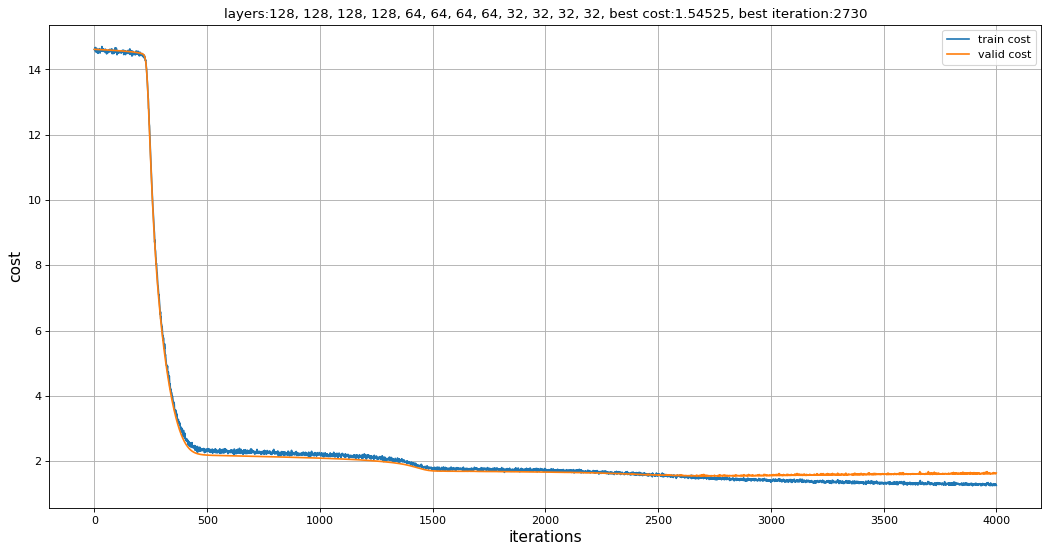

INFO:tensorflow:Restoring parameters from ./model_files/model-2730
Finished training and creating submission file for model :


In [51]:
ops.reset_default_graph()
# input and output dimensions
input_dim = len(features)
output_dim = 1
# batch size
batch_size = X_train.shape[0]//2
# max iteration
max_iter = 4000
stddev = 0.005
learning_rate = (1e-4)*1
layers = [128,128,128,128,64,64,64,64,32,32,32,32]
X, y, y_, keep_prob, cost, train_step = create_dnn_graph(layers, input_dim, output_dim, stddev, learning_rate)
saver = tf.train.Saver(max_to_keep=1)
model_name = "model"
train_cost, valid_cost, model_path, best_cost, best_iteration = train_graph(saver, max_iter, batch_size, 
                                                                            X_train, y_train, X_valid, y_valid,X, y, y_,
                                                                            keep_prob, cost, train_step, model_name)
# Show and save a graph of loss vs iterations
plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(train_cost, label = 'train cost')
plt.plot(valid_cost, label = 'valid cost')
plt.xlabel('iterations', fontsize = 14)
plt.ylabel('cost', fontsize = 14)
plt.title("layers:"+str(layers)[1:-1]+", best cost:"+str(best_cost)+", best iteration:"+str(best_iteration), fontsize = 12)
plt.legend()
plt.grid()
plt.show()
# figure path directory
figure_dir = "./model_cost_figures/"
plt.savefig(figure_dir + model_name+'.png', bbox_inches='tight')

# create submission dataframe using the saver object and model path
submission = compute_predictions(saver, model_path, X_test, y_, keep_prob, verbose = False)
# submission path dirrectory
submission_path_dir = "./submission_files/"
# save the sumission file
submission.to_csv(submission_path_dir+model_name+"_submission.csv", header = True, index=False)
print("Finished training and creating submission file for "+model_name+" :")

### 3.5 Train multiple models using randomly generated hyperparameters

 [N/A%] |                           | (train_loss: ------) (valid_loss: ------)

Training model_1 :


 [100%] |###########################| (train_loss:   1.24) (valid_loss:   1.69)


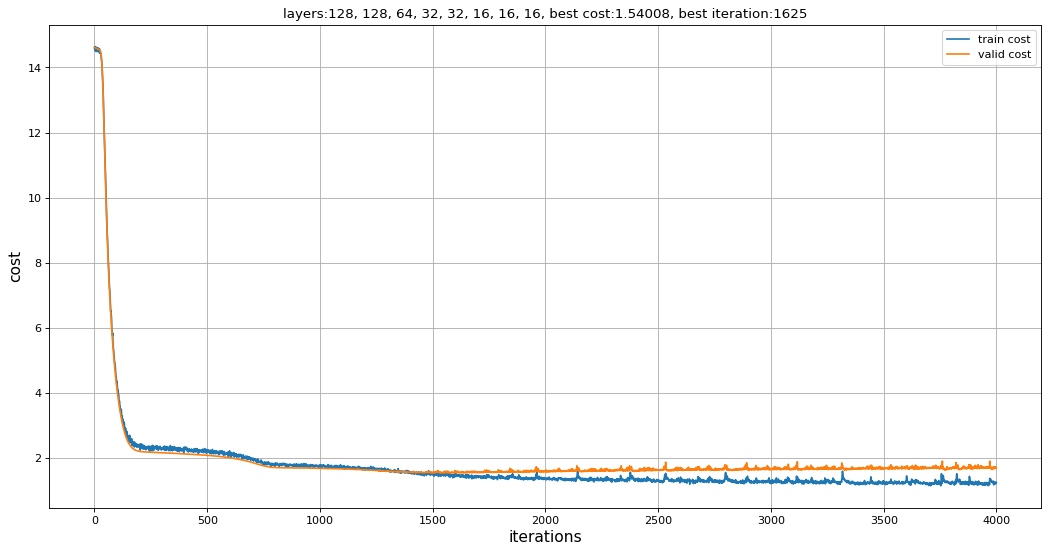

INFO:tensorflow:Restoring parameters from ./model_files/model_1-1625
Finished training and creating submission file for model_1 :
Training model_2 :


 [100%] |###########################| (train_loss:   1.35) (valid_loss:   1.68)


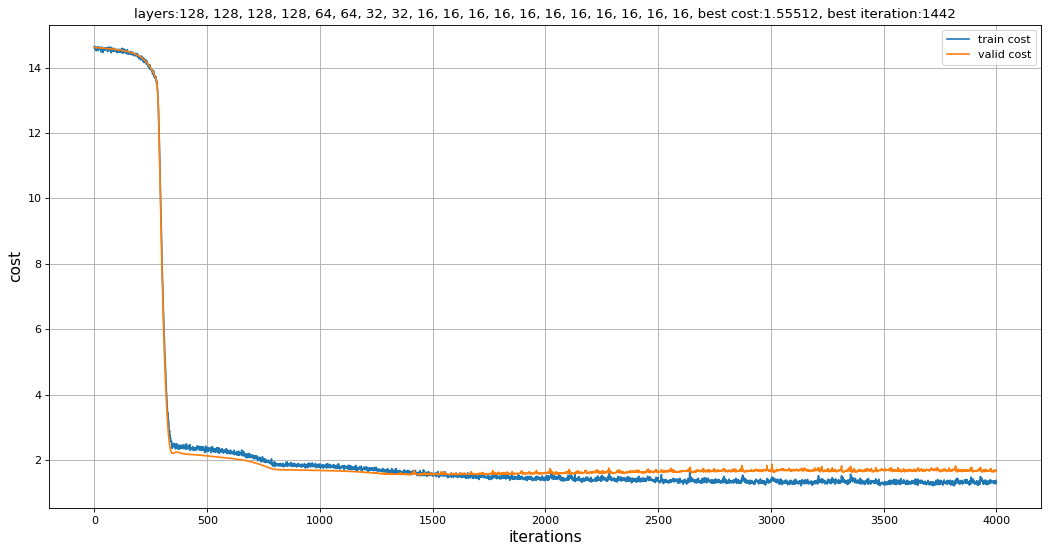

INFO:tensorflow:Restoring parameters from ./model_files/model_2-1442
Finished training and creating submission file for model_2 :
Training model_3 :


 [100%] |###########################| (train_loss:   1.19) (valid_loss:   1.83)


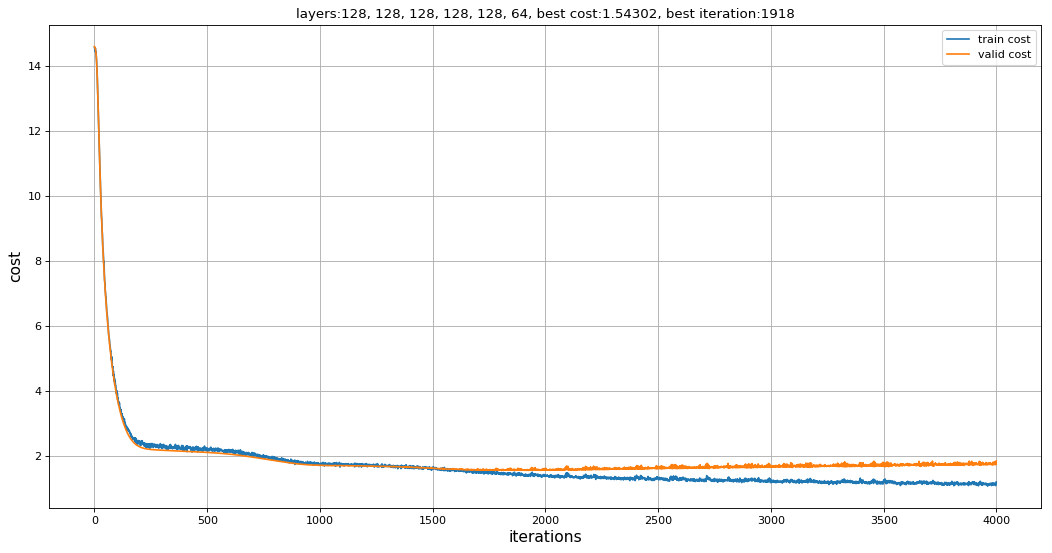

INFO:tensorflow:Restoring parameters from ./model_files/model_3-1918
Finished training and creating submission file for model_3 :
Training model_4 :


 [100%] |###########################| (train_loss:   1.36) (valid_loss:   1.74)


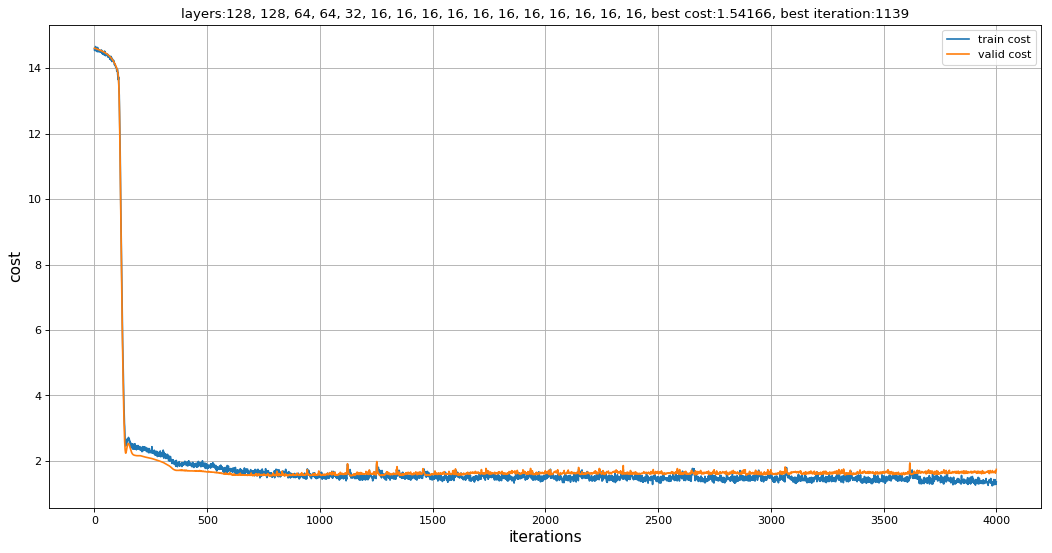

INFO:tensorflow:Restoring parameters from ./model_files/model_4-1139
Finished training and creating submission file for model_4 :
Training model_5 :


 [100%] |###########################| (train_loss:   1.22) (valid_loss:   1.88)


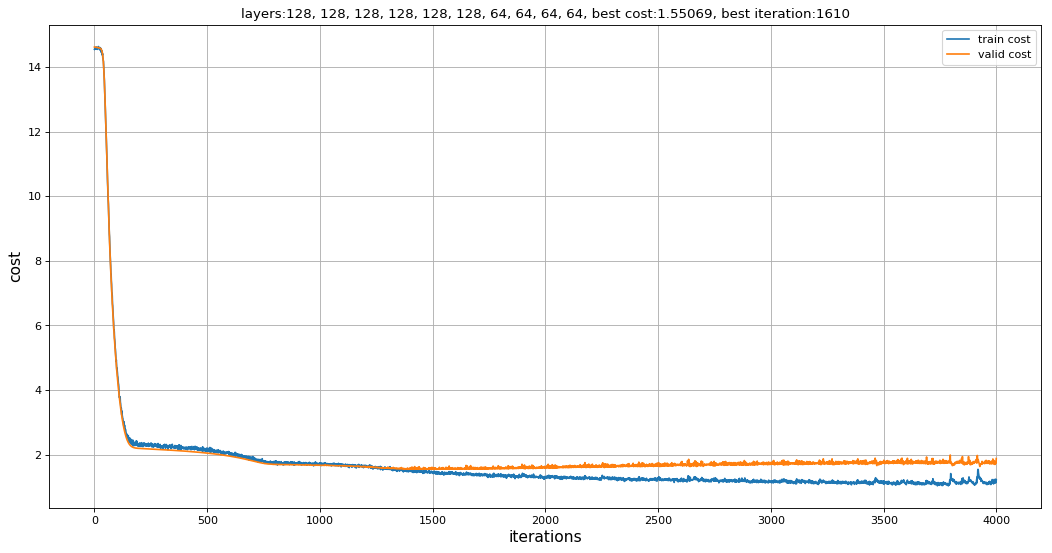

INFO:tensorflow:Restoring parameters from ./model_files/model_5-1610
Finished training and creating submission file for model_5 :
Training model_6 :


 [100%] |###########################| (train_loss:   1.18) (valid_loss:   1.69)


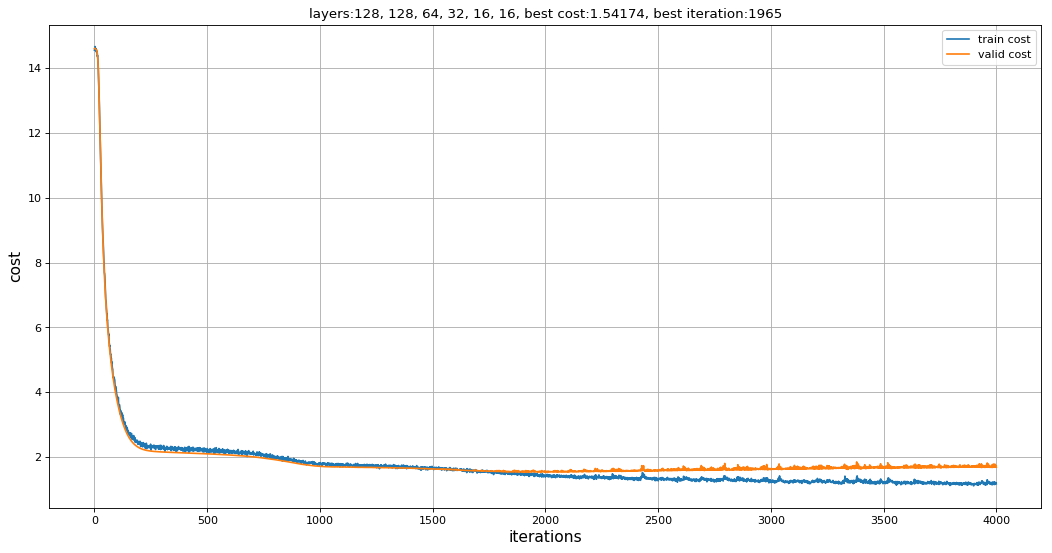

INFO:tensorflow:Restoring parameters from ./model_files/model_6-1965
Finished training and creating submission file for model_6 :
Training model_7 :


 [100%] |###########################| (train_loss:   1.19) (valid_loss:   1.69)


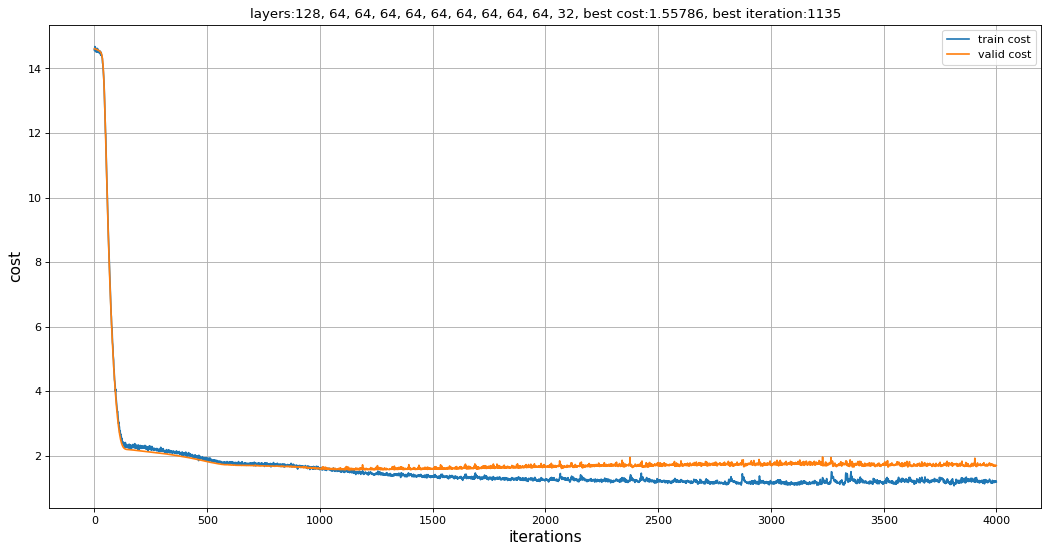

INFO:tensorflow:Restoring parameters from ./model_files/model_7-1135
Finished training and creating submission file for model_7 :
Training model_8 :


 [100%] |###########################| (train_loss:   1.86) (valid_loss:   1.74)


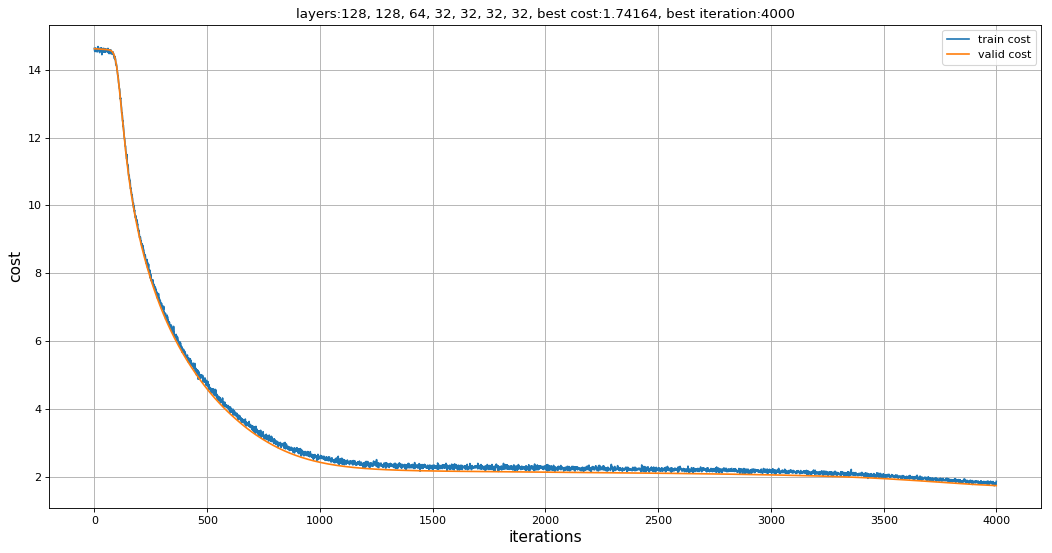

INFO:tensorflow:Restoring parameters from ./model_files/model_8-4000
Finished training and creating submission file for model_8 :


In [52]:
# input and output dimensions
input_dim = len(features)
output_dim = 1
# batch size
batch_size = X_train.shape[0]//2
# max iteration
max_iter = 4000
# counter variable
counter = 1
# list to store the best loss of all the models
best_costs = []

# iterate through learning rate, stddev, layers of architecture
for learning_rate, stddev, layers in zip(learning_rate_list, stddev_list, model_architecture_list):
    # create dnn regressor graph
    X, y, y_, keep_prob, cost, train_step = create_dnn_graph(layers, input_dim, output_dim, stddev, learning_rate)
    # create a saver object
    saver = tf.train.Saver(max_to_keep=1)
    # model name
    model_name = "model_"+str(counter)
    print("Training "+model_name+" :")
    # train dnn regressor
    train_cost, valid_cost, model_path, best_cost, best_iteration = train_graph(saver, max_iter, batch_size, 
                                                                                X_train, y_train, X_valid, y_valid, X, y, y_,
                                                                                keep_prob, cost, train_step, model_name)
    # append the best loss to the designated list
    best_costs.append(best_cost)
    
    # show and save a graph of cost vs iterations
    plt.figure(figsize=(16, 8), dpi= 80, facecolor='w', edgecolor='k')
    plt.plot(train_cost, label = 'train cost')
    plt.plot(valid_cost, label = 'valid cost')
    plt.xlabel('iterations', fontsize = 14)
    plt.ylabel('cost', fontsize = 14)
    plt.title("layers:"+str(layers)[1:-1]+", best cost:"+str(best_cost)+", best iteration:"+str(best_iteration), fontsize = 12)
    plt.legend()
    plt.grid()
    plt.show()
    # figure path directory
    figure_dir = "./model_cost_figures/"
    plt.savefig(figure_dir + model_name+'.png', bbox_inches='tight')
    
    # create submission dataframe using the saver object and model path
    submission = compute_predictions(saver, model_path, X_test, y_, keep_prob, verbose = False)
    # submission path dirrectory
    submission_path_dir = "./submission_files/"
    # save the sumission file
    submission.to_csv(submission_path_dir+model_name+"_submission.csv", header = True, index=False)
    print("Finished training and creating submission file for "+model_name+" :")
    
    counter += 1

**Tabulate the results of the models**

In [53]:
results = pd.DataFrame({"Layers": model_architecture_list, "Learning rate": learning_rate_list, "Stddev":stddev_list, "Best Cost":best_costs})
results = results[["Layers", "Learning rate", "Stddev", "Best Cost"]]

**Show the results**

In [54]:
results.head(numbers)

,Layers,Learning rate,Stddev,Best Cost
0,"[128, 128, 64, 32, 32, 16, 16, 16]",0.0007,0.0139,1.540080
1,"[128, 128, 128, 128, 64, 64, 32, 32, 16, 16, 1...",0.0002,0.0149,1.555121
2,"[128, 128, 128, 128, 128, 64]",0.0004,0.0222,1.543025
3,"[128, 128, 64, 64, 32, 16, 16, 16, 16, 16, 16,...",0.0009,0.0238,1.541663
4,"[128, 128, 128, 128, 128, 128, 64, 64, 64, 64]",0.0002,0.0238,1.550687
5,"[128, 128, 64, 32, 16, 16]",0.0010,0.0062,1.541741
6,"[128, 64, 64, 64, 64, 64, 64, 64, 64, 64, 32]",0.0003,0.0345,1.557862
7,"[128, 128, 64, 32, 32, 32, 32]",0.0001,0.0081,1.741637


**Save the results**

In [55]:
results_dir = './'
results.to_csv(results_dir+'Results.csv',header = True, index=False)